<a href="https://colab.research.google.com/github/Alireza8Kh/the-DDPG-Method-Implemented-in-Pendulum-v1-Environment/blob/main/Copy_of_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install gym

In [2]:
# Importing the libraries

import os
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import matplotlib.pyplot as plt # Graphical library
import random
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.stats import ttest_1samp
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

**Helper Functions**

In [3]:
env = gym.make('Pendulum-v1', g = 9.81)

from gym.wrappers.time_limit import TimeLimit


class ShowPendulumPredictions(gym.Env):
    def __init__(self):

        self.env = gym.make('Pendulum-v1', g=9.81)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def render(self, mode="human"):

        return self.env.render(mode=mode)

    def close(self):
        """
        Close the environment.
        """
        self.env.close()

gym.envs.registration.register( id="PendulumPrediction-v1", entry_point = ShowPendulumPredictions, max_episode_steps=999 )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**the MLP class**

In [4]:
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):  # Check if the layer is a linear layer
            nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            if layer.bias is not None:  # Initialize biases to zeros
                nn.init.constant_(layer.bias, 0)



class MLP(nn.Module):

    def __init__(self, input_size, output_size, num_hidden, hidden_size):
        """
        Initialise the network.
        Input:
            - input_size {int} - size of input to the network
            - output_size {int} - size of output to the network
            - num_hidden {int} - number of hidden layers
            - hidden_size {int} - size of each hidden layer
        """
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) # First tranformation from the network input to the input of first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)]) # All the hidden transformation
        self.output_layer = nn.Linear(hidden_size, output_size) # Last tranformation from the last hidden layer output to the network output

    def forward(self, x):
        """
        Get the output of the MLP.
        Input: x {tensor} - one element or a batch of element
        Ouput: y {tensor} - corresponding output
        """
        x.to(device)
        x = self.input_layer(x) # Passing through the input layer
        x = F.relu(x) # Applying Relu activation
        for layer in self.hidden_layers:
          x = layer(x) # Passing through each hidden layer
          x = F.relu(x) # Applying Relu activation
        x = self.output_layer(x) # Passing through the output layer
        return x

**Batching the Data**

In [5]:
def batch_data(state_list, action_list, reward_list, next_state_list, batch_size):
    num_samples = len(state_list)
    sample_indices = random.sample(range(num_samples), batch_size)


    # Ensure tensors are correctly reshaped
    batched_state = torch.cat(
        [torch.tensor(state_list[i], dtype=torch.float32).view(1, -1) for i in sample_indices], dim=0
    )
    batched_action = torch.cat(
        [torch.tensor(action_list[i], dtype=torch.float32).view(1, -1) for i in sample_indices], dim=0
    )
    batched_reward = torch.cat(
        [torch.tensor([reward_list[i]], dtype=torch.float32).view(1, -1) for i in sample_indices], dim=0
    )
    batched_next_state = torch.cat(
        [torch.tensor(next_state_list[i], dtype=torch.float32).view(1, -1) for i in sample_indices], dim=0
    )

    return batched_state, batched_action, batched_reward, batched_next_state



**Some Usefull Modules**

In [6]:
def MSE_loss(prediction, target):

      return ((prediction - target)**2).sum(dim=-1).mean()

def soft_update(target_network, predictor_network, tau):
        """
        Softly updates the parameters of the target network.
        target_param = tau * predictor_param + (1 - tau) * target_param
        """
        for target_param, predictor_param in zip(target_network.parameters(), predictor_network.parameters()):
            target_param.data.copy_(tau * predictor_param.data + (1.0 - tau) * target_param.data)

def reset(self):
        """Reset the noise process to the mean."""
        self.x_prev = np.zeros_like(self.mu)

def sample(self):
        """Generate the next noise value."""
        x = (
            self.x_prev
            + self.theta * (self.mu - self.x_prev) * self.dt
            + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.action_dim)
        )
        self.x_prev = x
        return x

def soft_update(target, source, tau):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

def moving_average(data, window_size=10):
      return [sum(data[i:i+window_size])/window_size for i in range(len(data) - window_size)]

**Training Algorithm**

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:260: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
<ipython-input-5-b0a2ade5bdea>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  [torch.tensor([re

Epoch 2, Total Reward: -1114.64282099, Actor Loss: 5.9987487792968750, Last Twenty Mean: 5.6952541351318358
Epoch 3, Total Reward: -1461.59905006, Actor Loss: 10.2730455398559570, Last Twenty Mean: 9.5011851787567139
Epoch 4, Total Reward: -1228.97960833, Actor Loss: 14.1261444091796875, Last Twenty Mean: 14.0257171630859379
Epoch 5, Total Reward: -1563.81413379, Actor Loss: 20.2246189117431641, Last Twenty Mean: 20.2424821853637695
Epoch 6, Total Reward: -1794.31139402, Actor Loss: 27.1269569396972656, Last Twenty Mean: 27.0178956031799302
Epoch 7, Total Reward: -1392.47962364, Actor Loss: 33.8450736999511719, Last Twenty Mean: 33.7425044059753390
Epoch 8, Total Reward: -1416.22371637, Actor Loss: 38.7579879760742188, Last Twenty Mean: 39.3308544158935547
Epoch 9, Total Reward: -1320.11985536, Actor Loss: 45.7840728759765625, Last Twenty Mean: 45.8763284683227539
Epoch 10, Total Reward: -1157.68505207, Actor Loss: 51.8550148010253906, Last Twenty Mean: 50.8777690887451186
Epoch 11, To

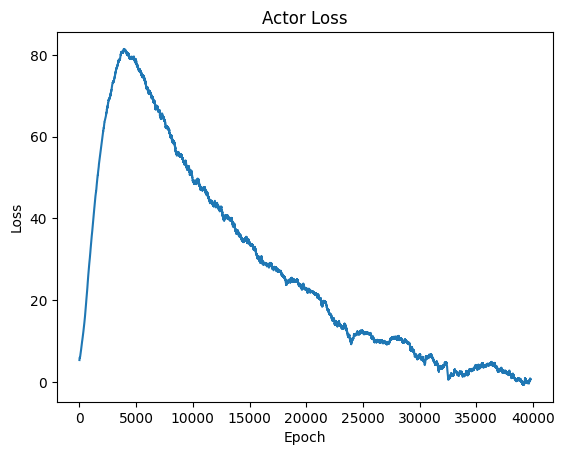

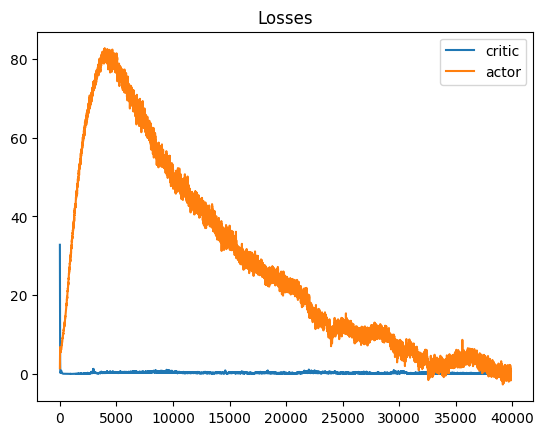

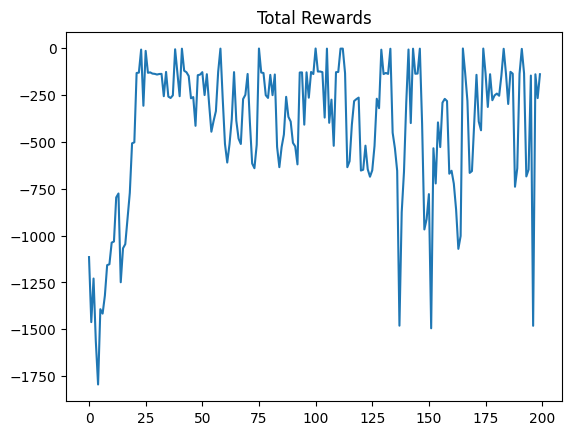

In [7]:
state_size = 3  # [cos(theta), sin(theta), theta_dot]
action_size = 1  # Torque
num_hidden = 2

# Define networks
predictor_actor = MLP(state_size, action_size, num_hidden, hidden_size=512)
predictor_critic = MLP(state_size + action_size, 1, num_hidden, hidden_size=512)
initialize_weights(predictor_actor)
initialize_weights(predictor_critic)

target_actor = MLP(state_size, action_size, num_hidden, hidden_size=512)
target_critic = MLP(state_size + action_size, 1, num_hidden, hidden_size=512)
initialize_weights(target_actor)
initialize_weights(target_critic)

# Training parameter
gamma = 0.99
max_epoche_number = 200
batch_size = 128
max_buffer_size = 50000
max_action = 2.0  # Torque bounds in Pendulum-v1
critic_learning_rate = 1e-3
actor_learning_rate = 4e-4
actor_loss = torch.tensor(0.0)

optimiser_critic = optim.Adam(predictor_critic.parameters(), lr = critic_learning_rate)
optimiser_actor = optim.Adam(predictor_actor.parameters(), lr = actor_learning_rate)

state_list, action_list, reward_list, next_state_list = [], [], [], []
total_reward_list, losses_critic, losses_actor = [], [], []

epoch = 1
previous_actor_loss = None  # Initialize previous actor loss

while epoch <= max_epoche_number:

    total_reward = 0
    state = env.reset()
    state[2] /= 10.0  # Normalize theta_dot
    done = False
    experience_counter = 0
    decay_factor = 0.998** epoch

    while not done:

        state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)
        action = predictor_actor(state_tensor).detach().numpy()
        noise_scale = max(0.7 * decay_factor, 0.05)
        noisy_action = action + noise_scale * np.random.normal(0, 0.2, size=action.shape)
        noisy_action = np.clip(noisy_action, -max_action, max_action)

        next_state, reward, done, truncated = env.step(noisy_action)
        done = done or truncated
        next_state[2] /= 10.0  # Normalize theta_dot

        # Store experience in the replay buffer
        state_list.append(state)
        action_list.append(noisy_action)
        reward_list.append(reward)
        next_state_list.append(next_state)
        total_reward += reward
        experience_counter += 1

        # Trim buffer if necessary
        if len(state_list) > max_buffer_size:
            state_list = state_list[-max_buffer_size:]
            action_list = action_list[-max_buffer_size:]
            reward_list = reward_list[-max_buffer_size:]
            next_state_list = next_state_list[-max_buffer_size:]

        # Train if buffer has enough samples
        if len(state_list) >= batch_size:
            batched_state, batched_action, batched_reward, batched_next_state = batch_data(
                state_list, action_list, reward_list, next_state_list, batch_size
            )

            target_miu = target_actor(batched_next_state)
            target_q = target_critic(torch.cat([batched_next_state, target_miu], dim=1)).detach()
            y = batched_reward + gamma * target_q

            # Update critic
            optimiser_critic.zero_grad()
            critic_loss = MSE_loss(predictor_critic(torch.cat([batched_state, batched_action], dim=1)), y)
            critic_loss.backward()
            #torch.nn.utils.clip_grad_norm_(predictor_critic.parameters(), 1)  # Gradient clipping
            optimiser_critic.step()

            # Update actor
            optimiser_actor.zero_grad()
            actions_pred = predictor_actor(batched_state)
            q_values = predictor_critic(torch.cat([batched_state, actions_pred], dim=1))
            actor_loss = -q_values.mean()

            for param_group in optimiser_actor.param_groups:
                param_group['lr'] = -actor_learning_rate if actor_loss.item() < 0 else actor_learning_rate

            actor_loss.backward()
            #torch.nn.utils.clip_grad_norm_(predictor_actor.parameters(), 1.0)  # Gradient clipping
            optimiser_actor.step()

            # Update target networks
            soft_update(target_actor, predictor_actor, tau = 0.005)
            soft_update(target_critic, predictor_critic, tau = 0.005)

            losses_critic.append(critic_loss.item())
            losses_actor.append(actor_loss.item())


        state = next_state

    total_reward_list.append(total_reward)

    # Update epoch
    epoch += 1

    # breaking the epoch loop after reaching the desired loss
    if len(losses_actor) >= 20:
        last_twenty_mean = sum(losses_actor[-20:]) / 20
    else:
       last_twenty_mean = sum(losses_actor[-20:]) / len(losses_actor)

    #if last_twenty_mean < 0 and epoch > 10:
     #   break

    # Print progress
    print(f"Epoch {epoch}, Total Reward: {sum(total_reward):.8f}, Actor Loss: {actor_loss.item():.16f}, Last Twenty Mean: {last_twenty_mean:.16f}")

env.close()

# Plotting results
smoothed_actor_loss = moving_average(losses_actor, window_size=100)
plt.plot(smoothed_actor_loss)
plt.title("Actor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(moving_average(losses_critic, 10))
plt.plot(moving_average(losses_actor, 10))
plt.legend(['critic', 'actor'])
plt.title("Losses")
plt.show()

plt.plot(total_reward_list)
plt.title("Total Rewards")
plt.show()




**Visualisation and Results**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Video saved in folder /content/learned_dynamics


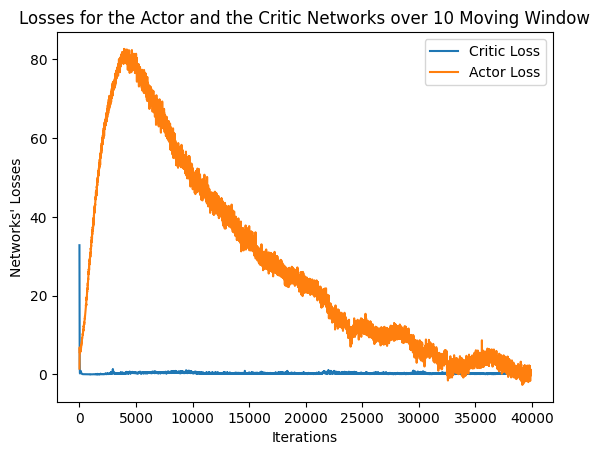

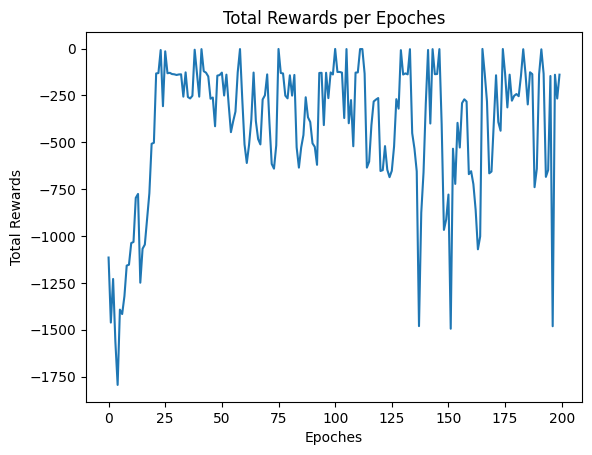

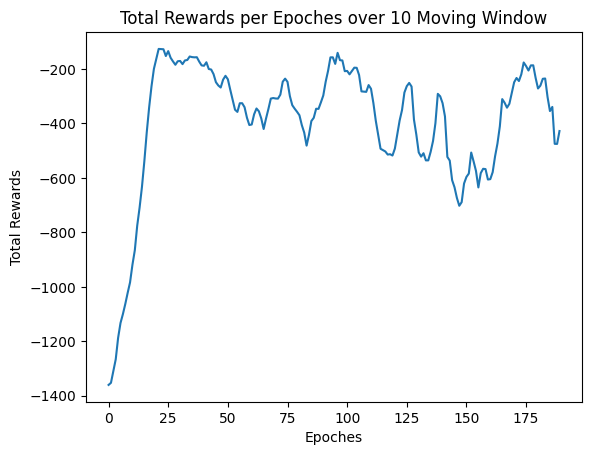

In [8]:
# Define directories
cwd = os.getcwd()
video_dir = os.path.join(cwd, 'learned_dynamics')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "learned_dynamics.mp4")

# Create the Pendulum environment
simulated_env = gym.make('Pendulum-v1', g=9.81, render_mode="rgb_array")

# Set up video recording
video_recorder = VideoRecorder(simulated_env, video_file, enabled=True)

# Reset the environment
state = simulated_env.reset()
if isinstance(state, tuple):  # Handle cases where reset returns a tuple
    state = state[0]

done = False

# Perform an episode
while not done:
    video_recorder.capture_frame()

    # Convert state to tensor
    state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)

    # Predict action using the actor network
    action = predictor_actor(state_tensor).detach().numpy()

    # Ensure action is a single number (for Pendulum)
    action = action.squeeze()  # Convert to scalar if it's an array of shape (1,)
    action = np.clip(action, -max_action, max_action)

    # Take a step in the environment
    next_state, reward, done, truncated = simulated_env.step([action])  # Action must be a list for Pendulum
    done = done or truncated
    next_state[2] /= 10.0  # Normalize theta_dot
    reward /= 1  # Normalize reward to [-1, 0]

    # Transition to next state
    state = next_state

# Finalize video recording
video_recorder.capture_frame()
video_recorder.close()
simulated_env.close()

print(f"Video saved in folder {video_dir}")

# Plot losses and rewards (assuming losses_critic, losses_actor, total_reward_list are defined)
if len(losses_critic) > 0 and len(losses_actor) > 0:
    plt.plot(moving_average(losses_critic, 10), label='Critic Loss')
    plt.plot(moving_average(losses_actor, 10), label='Actor Loss')
    plt.title("Losses for the Actor and the Critic Networks over 10 Moving Window")
    plt.xlabel("Iterations")
    plt.ylabel("Networks' Losses")
    plt.legend()
    plt.show()


if len(total_reward_list) > 0:
    plt.plot(total_reward_list)
    plt.title("Total Rewards per Epoches")
    plt.xlabel("Epoches")
    plt.ylabel("Total Rewards")
    plt.show()

if len(total_reward_list) > 0:
    plt.plot(moving_average(total_reward_list, 10))
    plt.title("Total Rewards per Epoches over 10 Moving Window")
    plt.xlabel("Epoches")
    plt.ylabel("Total Rewards")
    plt.show()




**Phase Diagram**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


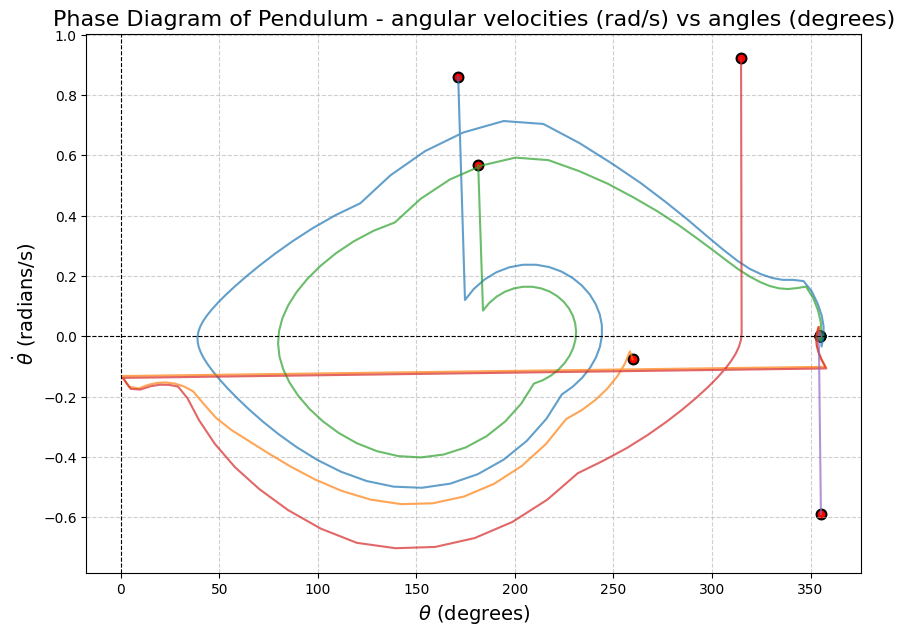

In [9]:


# Function to keep angles within the range [0, 360) degrees
def normalize_angle_to_360(theta):
    theta = np.rad2deg(theta)  # Convert to degrees
    while theta < 0:
        theta += 360
    while theta >= 360:
        theta -= 360
    return theta

# Number of random initial conditions to visualize
num_trajectories = 5
max_time_steps = 200  # Time limit for each trajectory

# Store the data for plotting
all_thetas = []
all_theta_dots = []
starting_points = []
final_points = []

for i in range(num_trajectories):
    # Reset the environment and get the initial state
    state = simulated_env.reset()
    thetas = []
    theta_dots = []

    # Extract initial theta and theta_dot for bold marker
    initial_theta = np.arctan2(state[1], state[0])  # Calculate the angle from cos(theta), sin(theta)
    initial_theta_dot = state[2]
    starting_points.append((normalize_angle_to_360(initial_theta), initial_theta_dot))

    for t in range(max_time_steps):
        theta = np.arctan2(state[1], state[0])  # Calculate the angle from cos(theta), sin(theta)
        theta = normalize_angle_to_360(theta)  # Normalize angle to [0, 360)

        theta_dot = state[2]

        thetas.append(theta)
        theta_dots.append(theta_dot)

        state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)

        # Predict action using the actor network
        action = predictor_actor(state_tensor).detach().numpy()
        action = np.clip(action.squeeze(), -max_action, max_action)

        # Take a step in the environment
        next_state, reward, done, truncated = simulated_env.step([action])
        done = done or truncated
        next_state[2] /= 10.0  # Normalize theta_dot
        reward /= 1

        # Transition to next state
        state = next_state

        if done or truncated:
            break

    all_thetas.append(thetas)
    all_theta_dots.append(theta_dots)
    final_points.append((thetas[-1], theta_dots[-1]))

# Plotting the phase diagram
plt.figure(figsize=(10, 7))

# Plot each trajectory with arrows
for i in range(num_trajectories):
    plt.plot(all_thetas[i], all_theta_dots[i], alpha=0.7, linewidth=1.5, label=f'Trajectory {i+1}' if i < 3 else '')

# Highlight starting points with red dots
starting_thetas, starting_theta_dots = zip(*starting_points)
plt.scatter(starting_thetas, starting_theta_dots, color='red', s=50, label='Starting Points', edgecolors='black', linewidth=1.5)

# Highlight final points with green dots
final_thetas, final_theta_dots = zip(*final_points)
plt.scatter(final_thetas, final_theta_dots, color='green', s=50, label='Final Points', edgecolors='black', linewidth=1.5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$\dot{\theta}$ (radians/s)', fontsize=14)
plt.title('Phase Diagram of Pendulum - angular velocities (rad/s) vs angles (degrees)', fontsize=16)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Vertical line at x=0
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



**Histogram of the Final Angles**

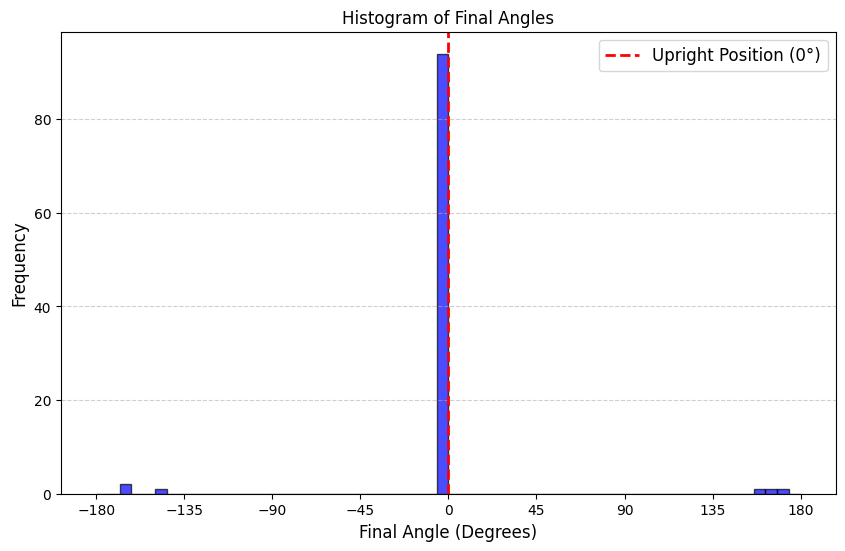

T-statistic: -1.1532915371187866
P-value: 0.25156760348525836
Fail to reject the null hypothesis: The mean is not significantly different from 0°.


In [10]:

# Number of random initial conditions to visualize
num_trajectories = 100  # Number of trajectories to simulate
max_time_steps = 200  # Time limit for each trajectory

# Store final angles
final_angles = []

for i in range(num_trajectories):
    # Reset the environment and get the initial state
    state = simulated_env.reset()

    for t in range(max_time_steps):
        theta = np.arctan2(state[1], state[0])  # Calculate the angle from cos(theta), sin(theta)
        theta = np.rad2deg(theta)  # Convert to degrees

        state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)

        # Predict action using the actor network
        action = predictor_actor(state_tensor).detach().numpy()
        action = np.clip(action.squeeze(), -max_action, max_action)

        # Take a step in the environment
        next_state, reward, done, truncated = simulated_env.step([action])
        done = done or truncated
        next_state[2] /= 10.0  # Normalize theta_dot
        reward /= 1

        # Transition to next state
        state = next_state

        if done or truncated:
            break  # Stop simulation when it ends

    # Append final angle to the list (constrained between -180 and 180)
    final_angles.append(theta)

# Ensure final_angles contains only the last angle of each trajectory
# Plotting the histogram of final angles
plt.figure(figsize=(10, 6))
plt.hist(final_angles, bins=60, range=(-180, 180), color='blue', alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Upright Position (0°)')
plt.xlabel('Final Angle (Degrees)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Final Angles', fontsize = 12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(np.arange(-180, 181, 45))  # Set x-axis ticks for better readability
plt.legend(fontsize=12)
plt.show()


# Final angles data
final_angles = np.array(final_angles)

# Perform one-sample t-test
t_stat, p_value = ttest_1samp(final_angles, 0)

# Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The mean is significantly different from 0°.")
else:
    print("Fail to reject the null hypothesis: The mean is not significantly different from 0°.")

